In [129]:
import gzip
import json
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
from surprise import Dataset, Reader
from surprise import accuracy
from surprise.model_selection.split import train_test_split
from collections import defaultdict
import math
import scipy.optimize
from sklearn import svm
import numpy
import string
import random
import string
from sklearn import linear_model
import random
from implicit import bpr
from nltk.stem.porter import *

# Load data

In [130]:
df = pd.read_json('./modcloth_final_data.json', lines = True)

In [131]:
df

,item_id,waist,size,quality,cup size,hips,bra size,category,bust,height,user_name,length,fit,user_id,shoe size,shoe width,review_summary,review_text
0,123373,29.0,7,5.0,d,38.0,34.0,new,36,5ft 6in,Emily,just right,small,991571,NaN,NaN,NaN,NaN
1,123373,31.0,13,3.0,b,30.0,36.0,new,NaN,5ft 2in,sydneybraden2001,just right,small,587883,NaN,NaN,NaN,NaN
2,123373,30.0,7,2.0,b,NaN,32.0,new,NaN,5ft 7in,Ugggh,slightly long,small,395665,9.0,NaN,NaN,NaN
3,123373,NaN,21,5.0,dd/e,NaN,NaN,new,NaN,NaN,alexmeyer626,just right,fit,875643,NaN,NaN,NaN,NaN
4,123373,NaN,18,5.0,b,NaN,36.0,new,NaN,5ft 2in,dberrones1,slightly long,small,944840,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82785,807722,NaN,8,4.0,b,NaN,36.0,outerwear,NaN,5ft 8in,Jennifer,just right,fit,727820,8.5,average,Cute jacket!,Cute jacket!
82786,807722,NaN,12,5.0,ddd/f,NaN,34.0,outerwear,NaN,5ft 5in,Kelli,slightly long,small,197040,NaN,NaN,It's a beautiful jacket.,It's a beautiful jacket. I love how it's knit ...
82787,807722,NaN,12,5.0,dddd/g,36.0,32.0,outerwear,NaN,5ft 4in,elacount,just right,fit,102493,NaN,NaN,I love this blazer. It is,I love this blazer. It is a great office piece...
82788,807722,NaN,12,4.0,NaN,NaN,NaN,outerwear,NaN,5ft 3in,jennaklinner,just right,fit,756491,NaN,NaN,I love this blazer!! I wo,I love this blazer!! I wore it yesterday and g...


In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82790 entries, 0 to 82789
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   item_id         82790 non-null  int64  
 1   waist           2882 non-null   float64
 2   size            82790 non-null  int64  
 3   quality         82722 non-null  float64
 4   cup size        76535 non-null  object 
 5   hips            56064 non-null  float64
 6   bra size        76772 non-null  float64
 7   category        82790 non-null  object 
 8   bust            11854 non-null  object 
 9   height          81683 non-null  object 
 10  user_name       82790 non-null  object 
 11  length          82755 non-null  object 
 12  fit             82790 non-null  object 
 13  user_id         82790 non-null  int64  
 14  shoe size       27915 non-null  float64
 15  shoe width      18607 non-null  object 
 16  review_summary  76065 non-null  object 
 17  review_text     76065 non-null 

# Feature preprocessing

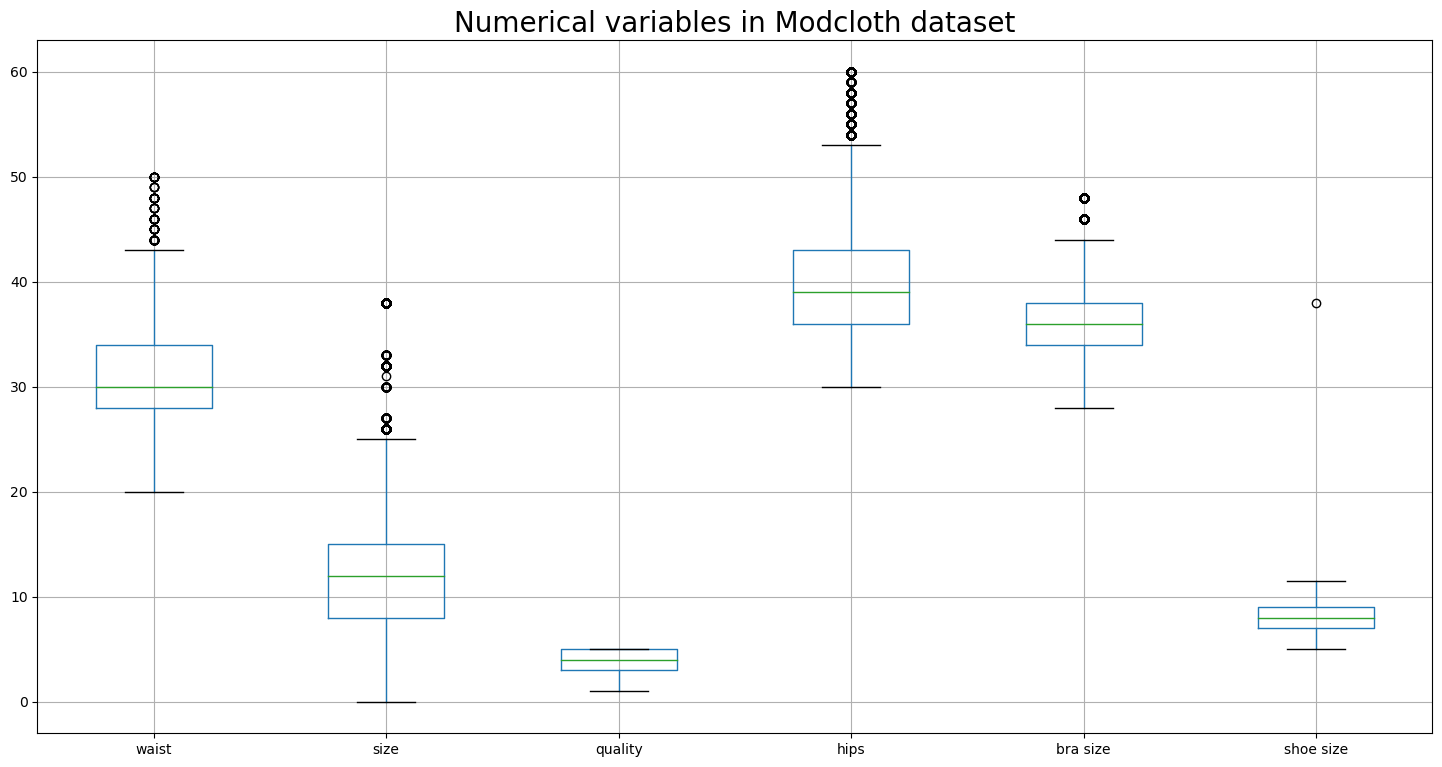

In [138]:
# Boxplot of numerical variables
cols = ['waist','size','quality','hips','bra size','shoe size']
plt.figure(figsize=(18,9))
df[cols].boxplot()
plt.title("Numerical variables in Modcloth dataset", fontsize=20)
plt.show()

([<matplotlib.patches.Wedge at 0x7f9228f73a30>,
 [Text(0.7541390848168467, 0.8007960044553227, 'new'),
  Text(-0.8137528796878374, 0.7401393455287676, 'tops'),
  Text(-0.8105435536526031, -0.7436525718588013, 'dresses'),
  Text(0.4869464567659842, -0.9863483909061005, 'bottoms'),
  Text(1.0244932359411167, -0.4005166781931802, 'outerwear'),
  Text(1.0925248145320823, -0.1280215983013781, 'sale'),
  Text(1.099940107979472, -0.011478626142007226, 'wedding')],
 [Text(0.4113485917182799, 0.4367978206119942, '26%'),
  Text(-0.4438652071024567, 0.4037123702884186, '25%'),
  Text(-0.44211466562869256, -0.4056286755593461, '23%'),
  Text(0.26560715823599135, -0.5380082132215093, '18%'),
  Text(0.5588144923315181, -0.21846364265082555, '5%'),
  Text(0.5959226261084084, -0.06982996270984258, '3%'),
  Text(0.5999673316251665, -0.006261068804731213, '0%')])

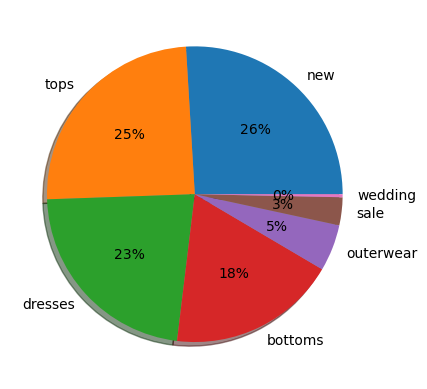

In [133]:
s = df['category'].value_counts()
plt.pie(s,labels = s.index, autopct='%1.0f%%', shadow=True)

([<matplotlib.patches.Wedge at 0x7f93074a7100>,
 [Text(-0.6055237179239344, 0.9183360098741503, 'fit'),
  Text(0.09954139832358697, -1.09548688263246, 'large'),
  Text(0.9693633424712507, -0.5199372176262869, 'small')],
 [Text(-0.33028566432214607, 0.5009105508404456, '69%'),
  Text(0.05429530817650197, -0.5975382996177054, '16%'),
  Text(0.5287436413479548, -0.2836021187052474, '16%')])

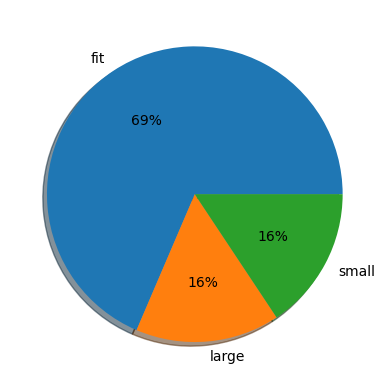

In [6]:
s = df['fit'].value_counts()
plt.pie(s,labels = s.index, autopct='%1.0f%%', shadow=True)

([<matplotlib.patches.Wedge at 0x7f93074f72e0>,
 [Text(-0.7741993298921677, 0.7814188362168645, 'just right'),
  Text(0.44674269385308085, -1.0051969784519315, 'slightly long'),
  Text(0.9730400986639257, -0.5130233585248316, 'slightly short'),
  Text(1.087126511792607, -0.16779734013874867, 'very long'),
  Text(1.0994889439295727, -0.03352703650239792, 'very short')],
 [Text(-0.422290543577546, 0.4262284561182897, '75%'),
  Text(0.24367783301077134, -0.5482892609737807, '14%'),
  Text(0.5307491447257776, -0.27983092283172634, '8%'),
  Text(0.5929780973414219, -0.0915258218938629, '3%'),
  Text(0.5997212421434032, -0.018287474455853405, '1%')])

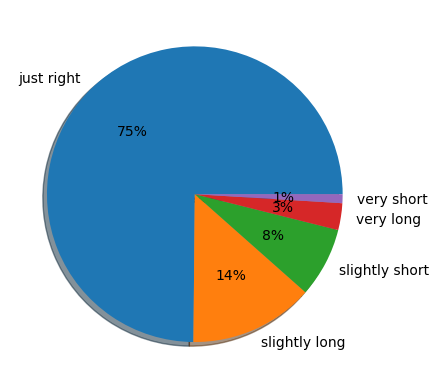

In [7]:
s = df['length'].value_counts()
plt.pie(s,labels = s.index, autopct='%1.0f%%', shadow=True)

In [8]:
pd.crosstab(df['length'], df['fit'])

fit,fit,large,small
length,,,
just right,45612,7549,8783
slightly long,6219,3768,1274
slightly short,3691,475,2153
very long,942,1211,275
very short,277,52,474


In [149]:
def get_cms(x):
    if type(x) == type(1.0):
        return
    #print(x)
    try:
        return (int(x[0])*30.48) + (int(x[4:-2])*2.54)
    except:
        return (int(x[0])*30.48)
df.height = df.height.apply(get_cms)

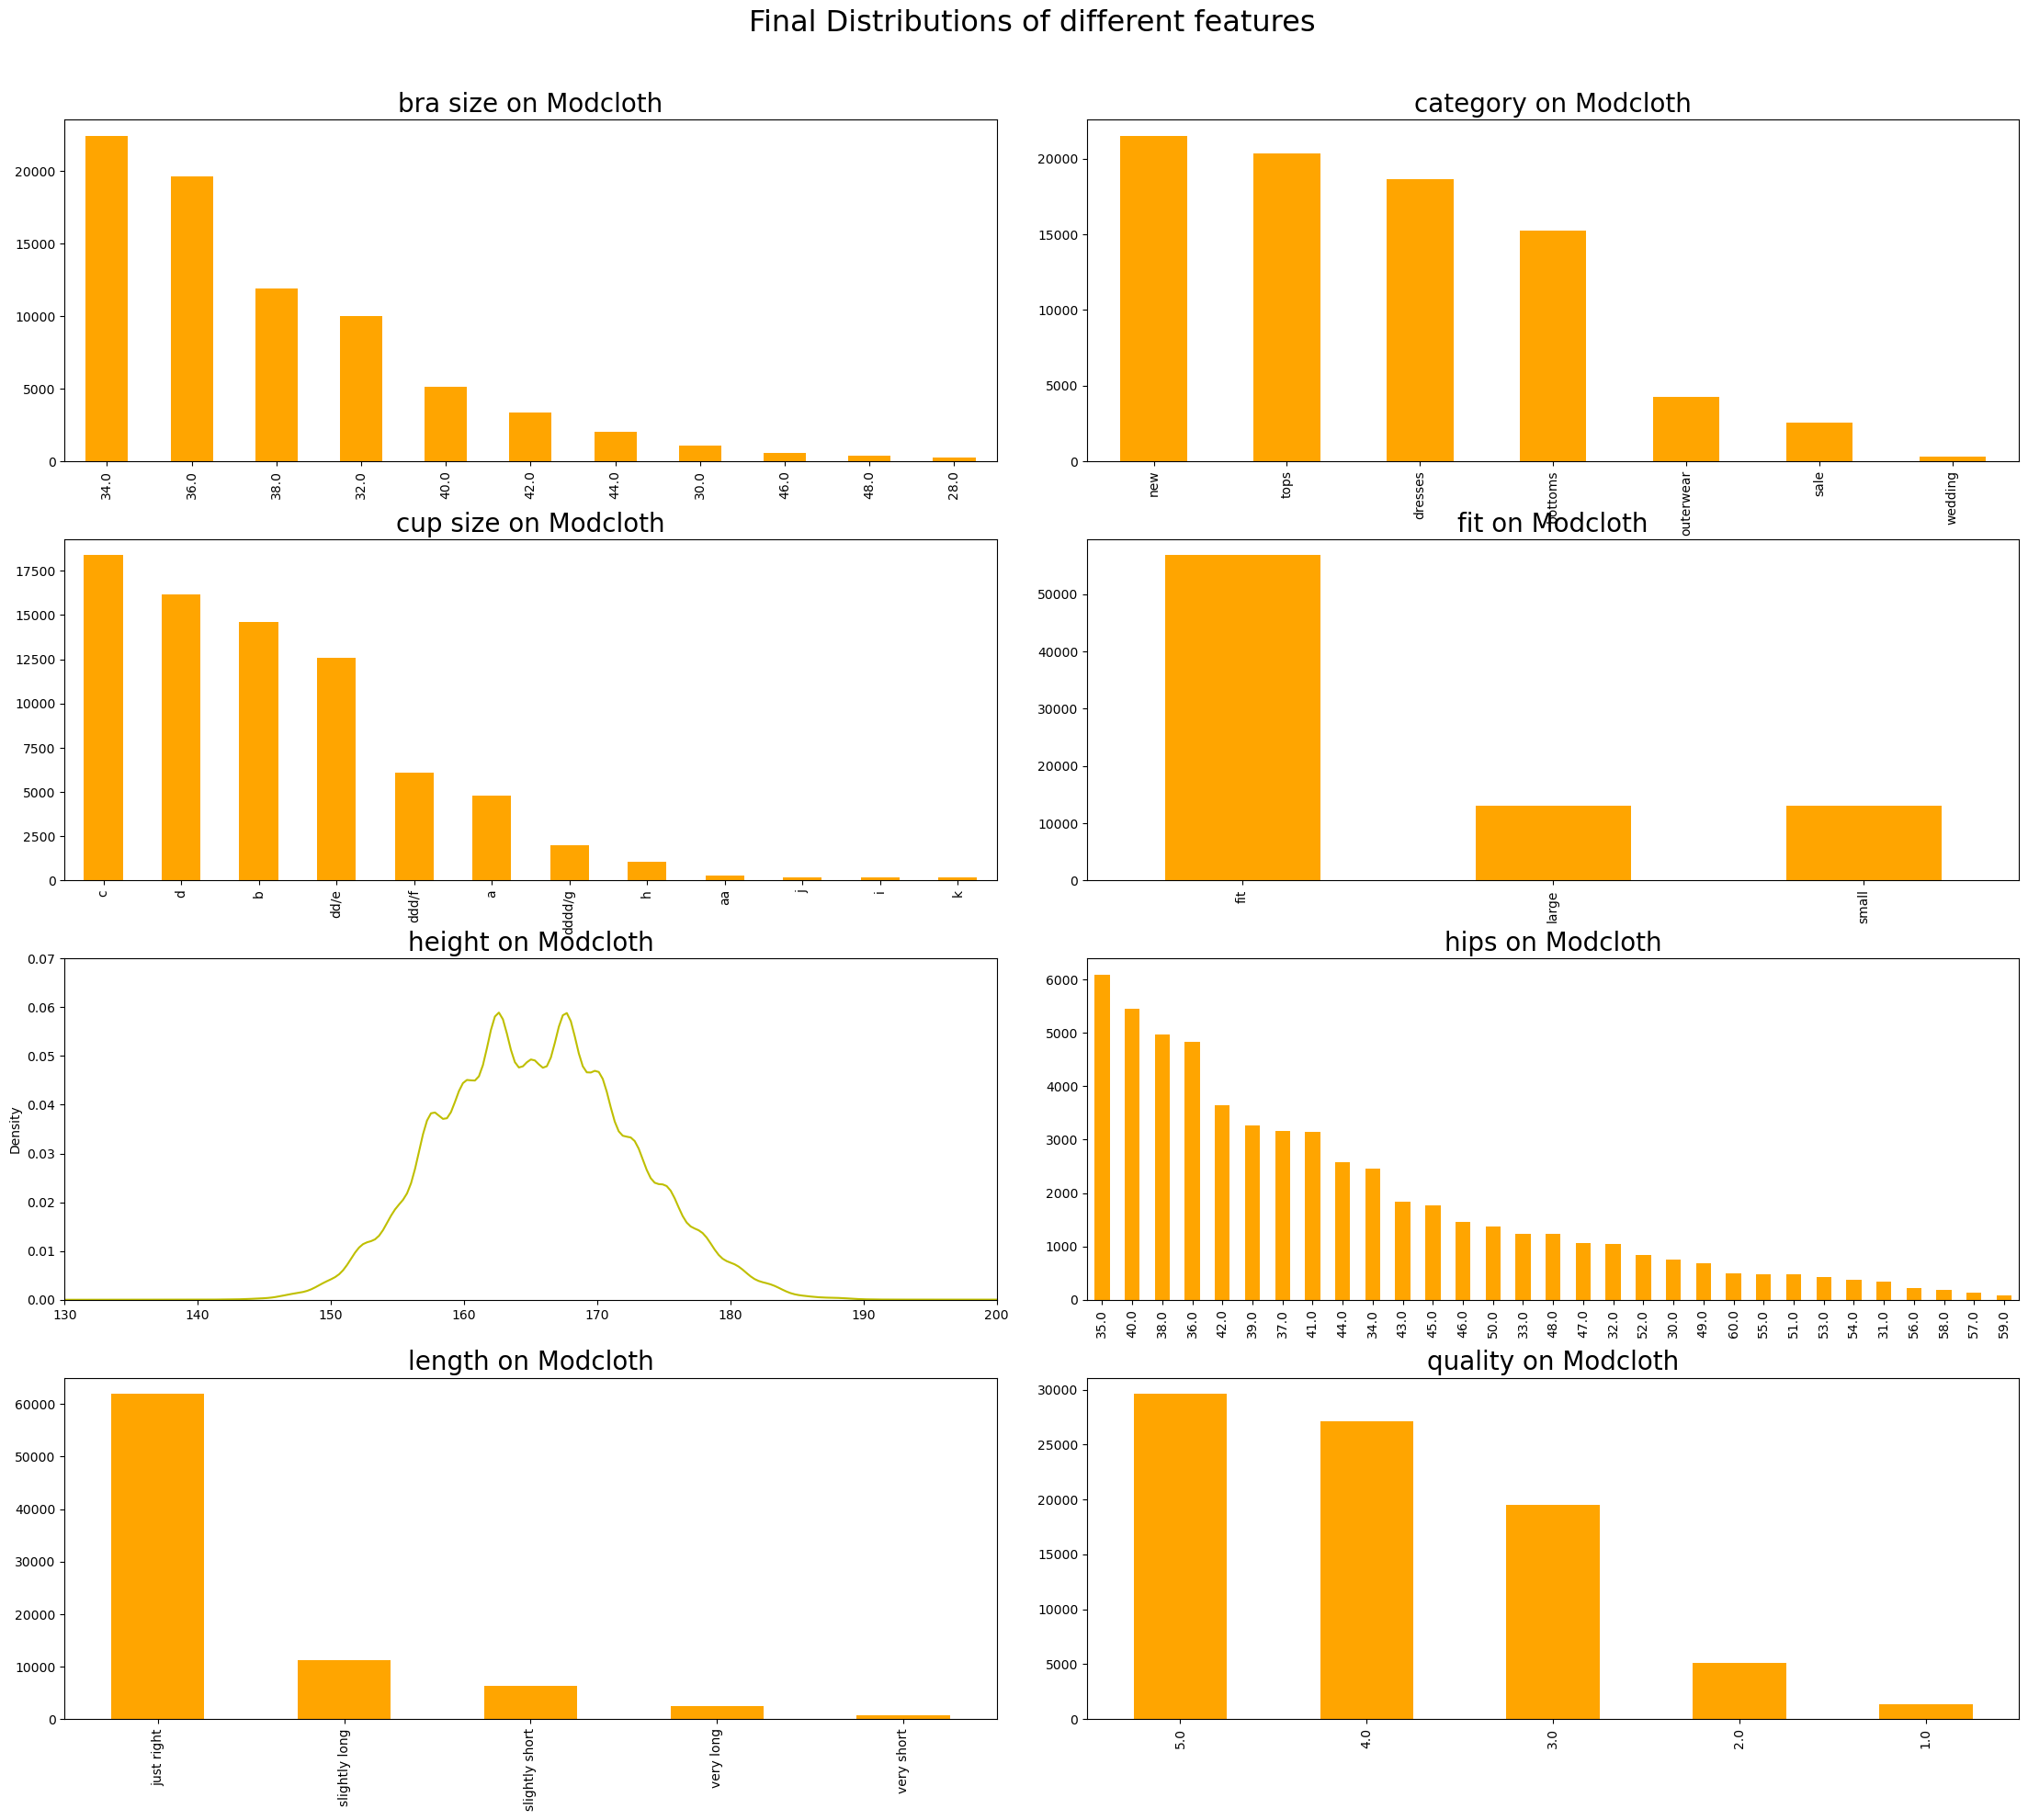

In [182]:
def plot_dist(col, ax):
    if col != 'height':
        df[col].value_counts().plot(kind='bar', facecolor='orange', ax=ax)
    else:
        df[col].plot(kind='density', ax=ax, bw_method = 0.15, color='y')
        ax.set_xlim(130,200)
        ax.set_ylim(0, 0.07)
    # ax.set_xlabel('{}'.format(col), fontsize=20)
    ax.set_title("{} on Modcloth".format(col), fontsize= 20)
    return ax

f, ax = plt.subplots(4,2, figsize = (22,20))
f.tight_layout(h_pad=4, w_pad=4, rect=[0, 0.03, 1, 0.93])
cols = ['bra size','category', 'cup size', 'fit', 'height', 'hips', 'length', 'quality']
k = 0
for i in range(4):
    for j in range(2):
        plot_dist(cols[k], ax[i][j])
        k += 1
__ = plt.suptitle("Final Distributions of different features", fontsize= 23)

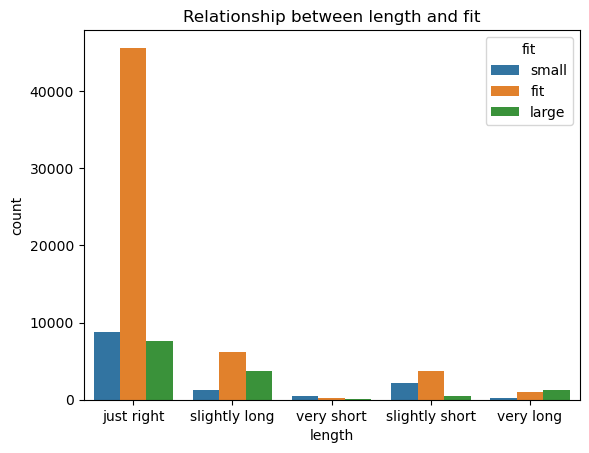

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x='length', hue='fit', data=df)
plt.title("Relationship between length and fit")
plt.show()

# Categories vs. Fit/Length/Quality

In [184]:
def plot_barh(df,col, cmap = None, stacked=False, norm = None):
    df.plot(kind='barh', colormap=cmap, stacked=stacked)
    fig = plt.gcf()
    fig.set_size_inches(24,12)
    plt.title("Category vs {}-feedback -  Modcloth {}".format(col, '(Normalized)' if norm else ''), fontsize= 20)
    plt.ylabel('Category', fontsize = 18)
    plt.xlabel('Frequency (Counts)', fontsize=18)

def norm_counts(t):
    norms = numpy.linalg.norm(t.fillna(0), axis=1)
    t_norm = t[0:0]
    for row, euc in zip(t.iterrows(), norms):
        t_norm.loc[row[0]] = list(map(lambda x: x/euc, list(row[1])))
    return t_norm

/var/folders/92/fpkqf45j7l1_b677fd4zfbc00000gn/T/ipykernel_81360/1090372018.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t_norm.loc[row[0]] = list(map(lambda x: x/euc, list(row[1])))
/var/folders/92/fpkqf45j7l1_b677fd4zfbc00000gn/T/ipykernel_81360/1090372018.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t_norm.loc[row[0]] = list(map(lambda x: x/euc, list(row[1])))
/var/folders/92/fpkqf45j7l1_b677fd4zfbc00000gn/T/ipykernel_81360/1090372018.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/panda

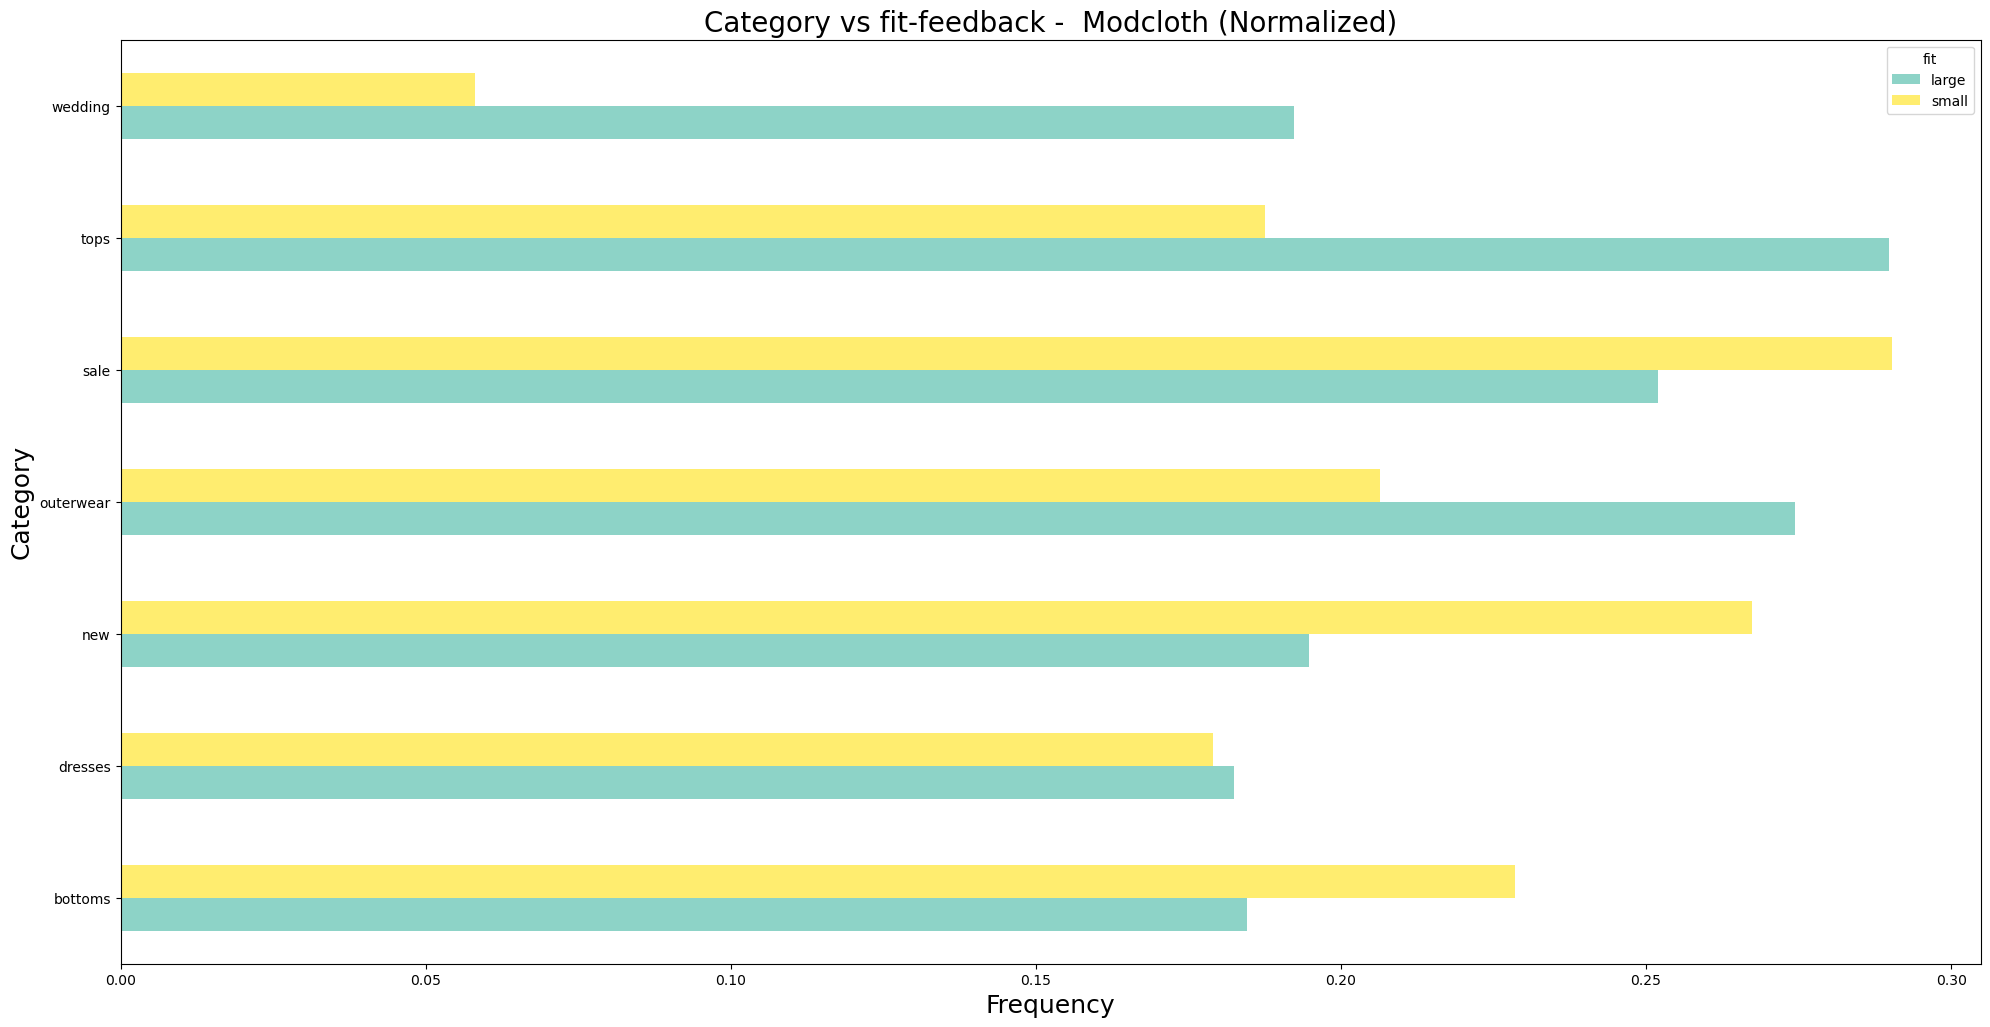

In [188]:
# Category vs Fit
# 1. Wedding, tops, & outerwear categories usually have more returns due to large sizing.
# 2. New, sale, & bottoms usually have frequent returns due to small sized buys.
g_by_category = df.groupby('category')
cat_fit = g_by_category['fit'].value_counts()
cat_fit = cat_fit.unstack()
cat_fit_norm = norm_counts(cat_fit)
cat_fit_norm.drop(['fit'], axis=1, inplace=True)
plot_barh(cat_fit_norm, 'fit', norm=1, cmap='Set3')

/var/folders/92/fpkqf45j7l1_b677fd4zfbc00000gn/T/ipykernel_81360/1090372018.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t_norm.loc[row[0]] = list(map(lambda x: x/euc, list(row[1])))
/var/folders/92/fpkqf45j7l1_b677fd4zfbc00000gn/T/ipykernel_81360/1090372018.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t_norm.loc[row[0]] = list(map(lambda x: x/euc, list(row[1])))
/var/folders/92/fpkqf45j7l1_b677fd4zfbc00000gn/T/ipykernel_81360/1090372018.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/panda

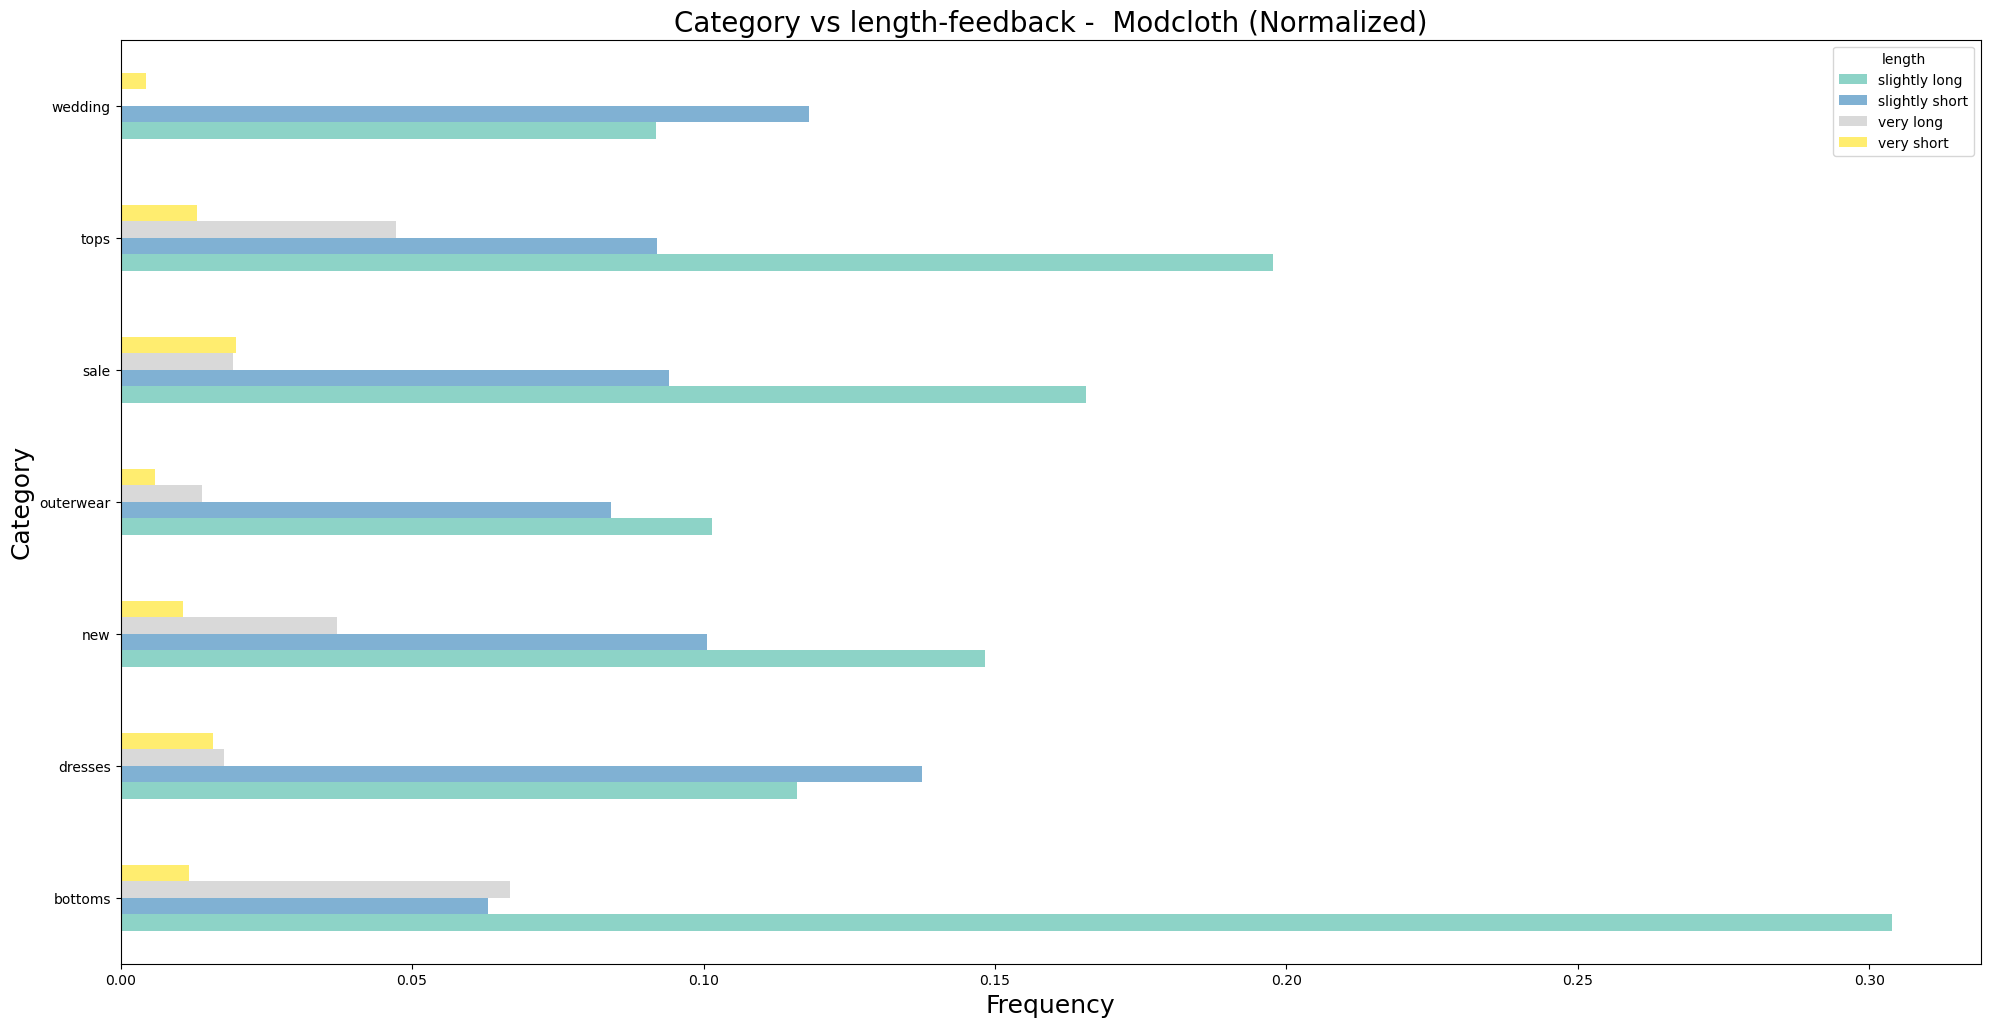

In [186]:
# Category vs Length
# 1. Customers tend to make 'slightly long' purchases in bottoms, new, sale, & tops categories.
# 2. 'slightly short' returns take place mostly in dresses and wedding categories.
cat_len = g_by_category['length'].value_counts()
cat_len = cat_len.unstack()
cat_len_norm = norm_counts(cat_len)
cat_len_norm.drop(['just right'], axis = 1, inplace=True)
plot_barh(cat_len_norm, 'length', cmap='Set3', norm=1)

/var/folders/92/fpkqf45j7l1_b677fd4zfbc00000gn/T/ipykernel_81360/1090372018.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t_norm.loc[row[0]] = list(map(lambda x: x/euc, list(row[1])))
/var/folders/92/fpkqf45j7l1_b677fd4zfbc00000gn/T/ipykernel_81360/1090372018.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t_norm.loc[row[0]] = list(map(lambda x: x/euc, list(row[1])))
/var/folders/92/fpkqf45j7l1_b677fd4zfbc00000gn/T/ipykernel_81360/1090372018.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/panda

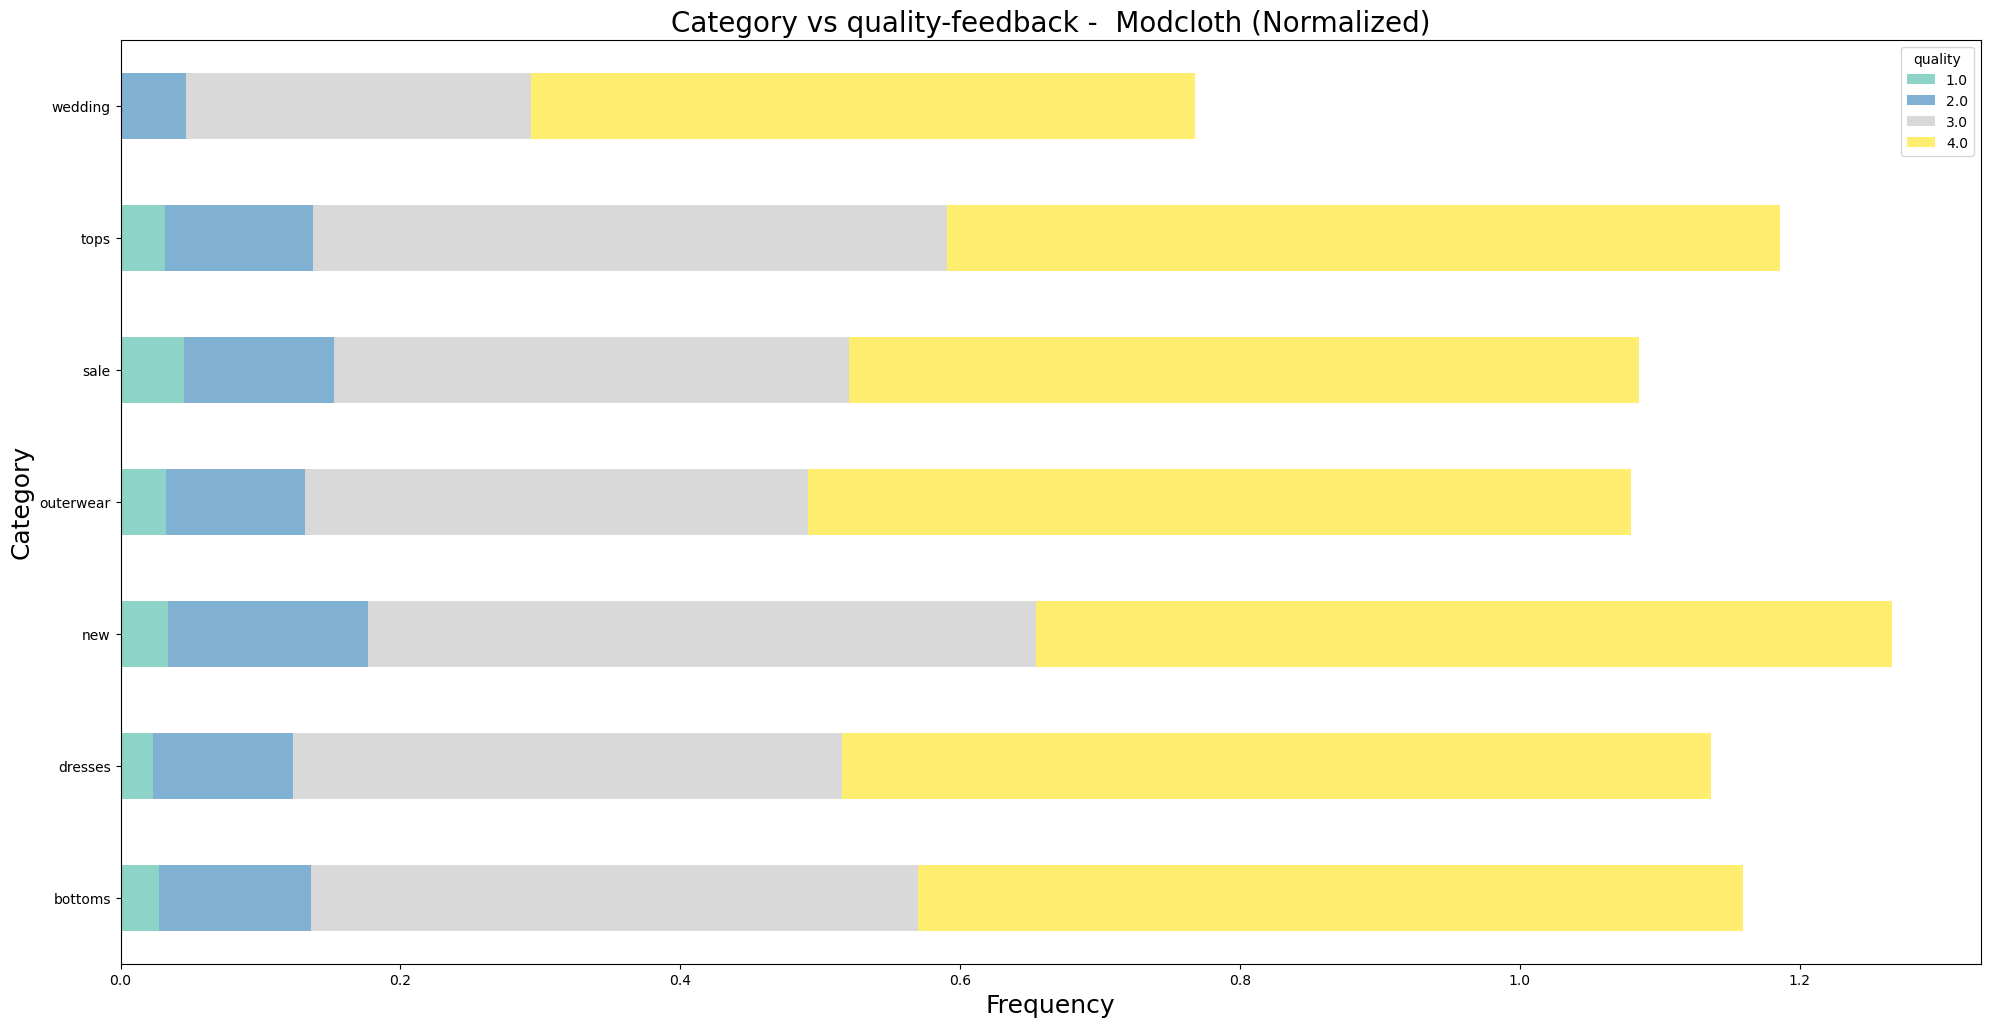

In [189]:
# Category vs Quality
# all the categories show similar trend of ratings.
cat_quality = g_by_category['quality'].value_counts()
cat_quality = cat_quality.unstack()
cat_quality_norm = norm_counts(cat_quality)
cat_quality_norm.drop([5.0], axis = 1, inplace=True)
plot_barh(cat_quality_norm, 'quality', 'Set3', stacked=1, norm=1)

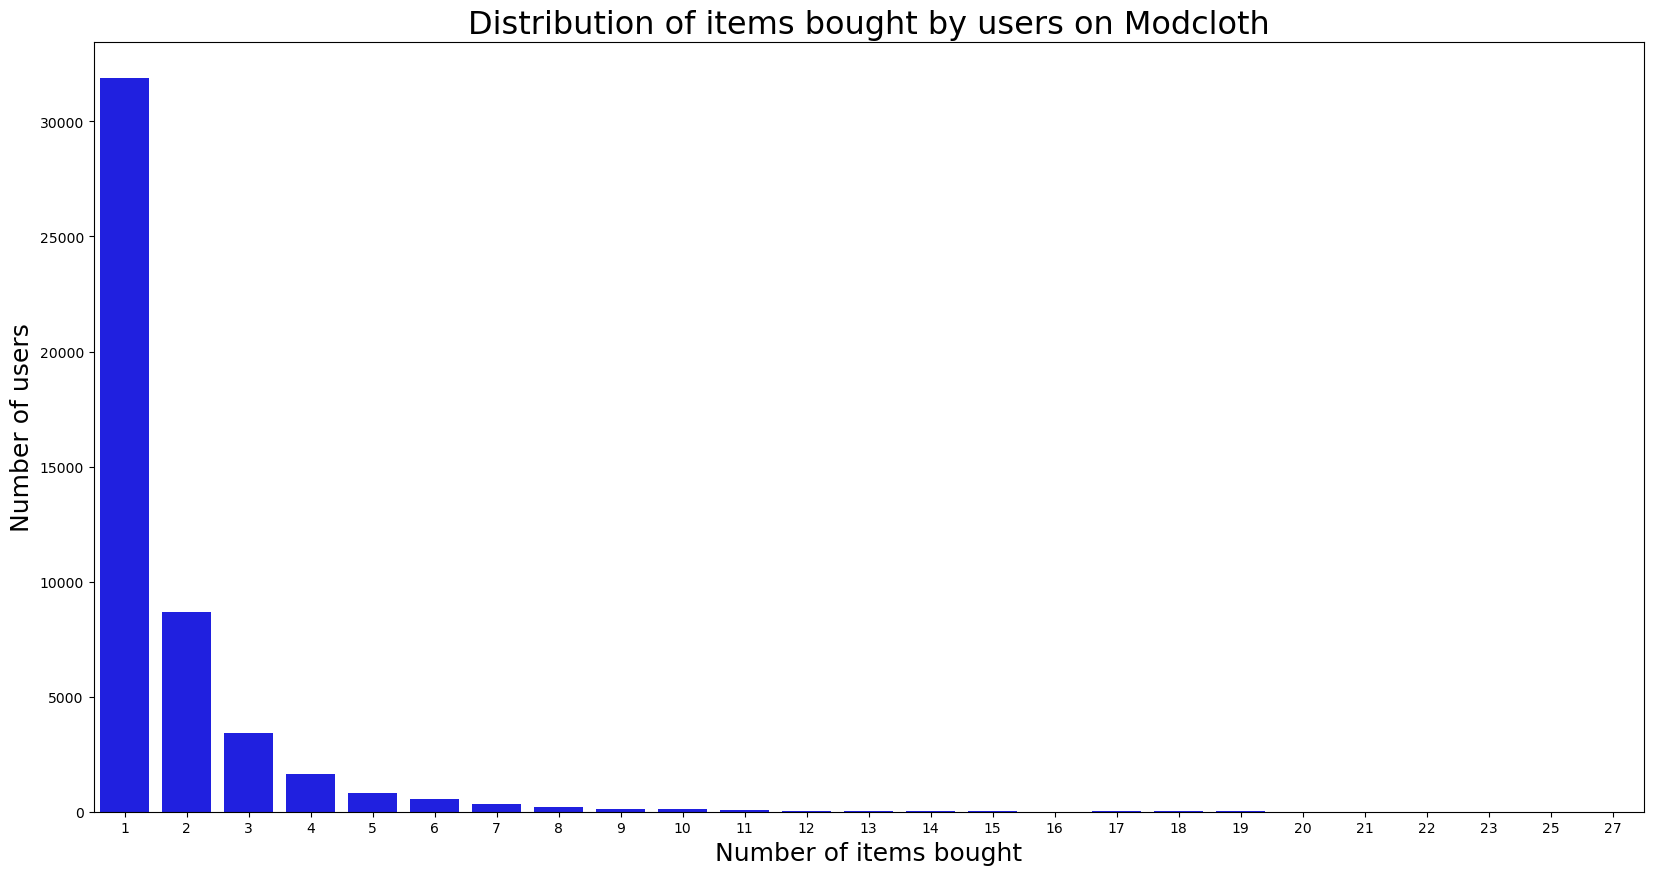

In [192]:
# Users who bought so many items
# A major chunk of the users (~40%) have only bought 1 item from Modcloth
items_bought = []
total_users = []
for i in range(min(df.user_id.value_counts()), max(df.user_id.value_counts())+1):
    all_users = sum(df.user_id.value_counts() == i)
    if all_users != 0:
        total_users.append(all_users)
        items_bought.append(i)
plt.xlabel("Number of items bought", fontsize = 18)
plt.ylabel("Number of users", fontsize = 18)
plt.title("Distribution of items bought by users on Modcloth", fontsize=23)
__ = sns.barplot(x=items_bought, y=total_users, color='b')
fig = plt.gcf()
fig.set_size_inches(20,10)

# Bag-of-words models

In [79]:
wordCount = defaultdict(int)
for ind in df.index:
    for w in str(df['review_text'][ind]).split():
        wordCount[w] += 1
len(wordCount)

59954

In [83]:
# Ignore capitalization and remove punctuation with stemming
wordCount = defaultdict(int)
punctuation = set(string.punctuation)
stemmer = PorterStemmer()
for ind in df.index:
  r = ''.join([c for c in str(df['review_text'][ind]).lower() if not c in punctuation])
  for w in r.split():
    w = stemmer.stem(w)
    wordCount[w] += 1

len(wordCount)

21880

In [85]:
counts = [(wordCount[w], w) for w in wordCount]
counts.sort()
counts.reverse()

In [86]:
words = [x[1] for x in counts[:1000]]

In [87]:
words

['the',
 'i',
 'it',
 'a',
 'and',
 'is',
 'this',
 'to',
 'but',
 'in',
 'for',
 'my',
 'of',
 'so',
 'love',
 'with',
 'was',
 'dress',
 'on',
 'its',
 'that',
 'have',
 'very',
 'me',
 'not',
 'great',
 'wear',
 'fit',
 'be',
 'just',
 'im',
 'like',
 'too',
 'little',
 'up',
 'perfect',
 'as',
 'are',
 'size',
 'skirt',
 'would',
 'they',
 'really',
 'or',
 'cute',
 'you',
 'bit',
 'fabric',
 'these',
 'color',
 'if',
 'material',
 'one',
 'at',
 'than',
 'all',
 'waist',
 'because',
 'fits',
 'long',
 'more',
 'top',
 'small',
 'length',
 'quality',
 'well',
 'am',
 'had',
 'when',
 'look',
 'them',
 'get',
 'nice',
 'good',
 'comfortable',
 'out',
 'will',
 'can',
 'shirt',
 'nan',
 'flattering',
 'an',
 'large',
 'super',
 'only',
 'still',
 'also',
 'about',
 'looks',
 'work',
 'big',
 'much',
 'soft',
 'short',
 'down',
 'other',
 'which',
 'got',
 'tight',
 'bought',
 'right',
 'cardigan',
 'though',
 'back',
 'dont',
 'ordered',
 'even',
 'enough',
 'has',
 'from',
 'way',
 

In [88]:
wordId = dict(zip(words, range(len(words))))
wordSet = set(words)

In [89]:
def feature(df, ind):
    feat = [0]*len(words)
    r = ''.join([c for c in str(df['review_text'][ind]).lower() if not c in punctuation])
    for w in r.split():
        if w in words:
            feat[wordId[w]] += 1
    feat.append(1) # offset
    return feat

In [92]:
new_df = df.dropna(subset = ['quality'], inplace=False)

In [93]:
X = [feature(new_df, ind) for ind in new_df.index]
y = [new_df['quality'][ind] for ind in new_df.index]

In [110]:
# Regularized regression
clf = linear_model.Ridge(1.0, fit_intercept=False) # MSE + 1.0 l2
clf.fit(X, y)
theta = clf.coef_
predictions = clf.predict(X)

In [95]:
def MSE(predictions, labels):
    differences = [(x-y)**2 for x,y in zip(predictions,labels)]
    return sum(differences) / len(differences)

In [96]:
MSE(predictions, y)

0.710409167484217

In [115]:
len(numpy.unique(predictions)), len(predictions)

(72109, 82722)

# N-grams

In [117]:
wordCount = defaultdict(int)
punctuation = set(string.punctuation)
for ind in new_df.index:
    r = ''.join([c for c in str(new_df['review_text'][ind]).lower() if not c in punctuation])
    ws = r.split()
    ws2 = [' '.join(x) for x in list(zip(ws[:-1],ws[1:]))]
    ws3 = [' '.join(x) for x in list(zip(ws[:-2],ws[1:-1],ws[2:]))]
    ws4 = [' '.join(x) for x in list(zip(ws[:-3],ws[1:-2],ws[2:-1],ws[3:]))]
    ws5 = [' '.join(x) for x in list(zip(ws[:-4],ws[1:-3],ws[2:-2],ws[3:-1],ws[4:]))]
    for w in ws + ws2 + ws3 + ws4 + ws5:
        wordCount[w] += 1

counts = [(wordCount[w], w) for w in wordCount]
counts.sort()
counts.reverse()

In [118]:
words = [x[1] for x in counts[:1000]]

In [119]:
words[200:210]

['at the',
 'pockets',
 'i love the',
 'coat',
 'bust',
 'dresses',
 'that i',
 'every',
 'i got',
 'did']

In [120]:
wordId = dict(zip(words, range(len(words))))
wordSet = set(words)

In [123]:
def feature(new_df, ind):
    feat = [0]*len(words)
    r = ''.join([c for c in str(new_df['review_text'][ind]).lower() if not c in punctuation])
    ws = r.split()
    ws2 = [' '.join(x) for x in list(zip(ws[:-1],ws[1:]))]
    ws3 = [' '.join(x) for x in list(zip(ws[:-2],ws[1:-1],ws[2:]))]
    ws4 = [' '.join(x) for x in list(zip(ws[:-3],ws[1:-2],ws[2:-1],ws[3:]))]
    ws5 = [' '.join(x) for x in list(zip(ws[:-4],ws[1:-3],ws[2:-2],ws[3:-1],ws[4:]))]
    for w in ws + ws2 + ws3 + ws4 + ws5:
        if w in words:
            feat[wordId[w]] += 1
    feat.append(1) #offset
    return feat

In [124]:
X = [feature(new_df, ind) for ind in new_df.index]
y = [new_df['quality'][ind] for ind in new_df.index]

In [125]:
clf = linear_model.Ridge(1.0, fit_intercept=False) # MSE + 1.0 l2
clf.fit(X, y)
theta = clf.coef_
predictions = clf.predict(X)

In [126]:
wordSort = list(zip(theta[:-1], words))
wordSort.sort()

In [127]:
wordSort[:20]

[(-0.7413341739553937, 'cheap'),
 (-0.46997018326650564, 'disappointed'),
 (-0.43797087578214766, 'thin'),
 (-0.43121172542493597, 'able to'),
 (-0.41267897190995545, 'love with'),
 (-0.39451936974822915, 'returned'),
 (-0.29918226653601954, 'returning'),
 (-0.2902111082269917, 'wanted to'),
 (-0.2774168287775627, 'a lot of'),
 (-0.22276119247113133, 'after'),
 (-0.21716454252908535, 'the first'),
 (-0.20580058404363977, 'weird'),
 (-0.2027339755920086, 'return'),
 (-0.19199463270037206, 'price'),
 (-0.18256327594103736, 'the zipper'),
 (-0.18218885348864033, 'in every color'),
 (-0.17487262207695975, 'decided to'),
 (-0.1724235117367158, 'up or down'),
 (-0.17150872644721918, 'the quality'),
 (-0.15863590820974696, 'easily')]

# Preprocessing - User, Item, Rating dataset

In [15]:
rating_df = df[['user_id','item_id', 'quality']]

In [16]:
rating_df

,user_id,item_id,quality
0,991571,123373,5.0
1,587883,123373,3.0
2,395665,123373,2.0
3,875643,123373,5.0
4,944840,123373,5.0
...,...,...,...
82785,727820,807722,4.0
82786,197040,807722,5.0
82787,102493,807722,5.0
82788,756491,807722,4.0


In [17]:
rating_df.dropna(how='any', inplace=True)
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82722 entries, 0 to 82789
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  82722 non-null  int64  
 1   item_id  82722 non-null  int64  
 2   quality  82722 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 2.5 MB


/var/folders/92/fpkqf45j7l1_b677fd4zfbc00000gn/T/ipykernel_81360/543149904.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_df.dropna(how='any', inplace=True)


In [18]:
rating_df.describe()

,user_id,item_id,quality
count,82722.000000,82722.000000,82722.000000
mean,498814.293900,469317.322756,3.949058
std,286379.344825,213996.309012,0.992783
min,6.000000,123373.000000,1.000000
25%,252860.000000,314980.000000,3.000000
50%,497768.000000,454030.000000,4.000000
75%,744745.250000,658440.000000,5.000000
max,999972.000000,807722.000000,5.000000


# Memory based Collaborative Filtering - Item based similarity

In [19]:
from surprise.prediction_algorithms import knns
from surprise.similarities import cosine, msd, pearson
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.model_selection import GridSearchCV
from surprise.model_selection.split import train_test_split

In [41]:
sim_cos = {'name':'cosine','user_based':False}
sim_pearson = {'name':'pearson','user_based':False}

In [22]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(rating_df[['user_id', 'item_id', 'quality']], reader)

In [24]:
trainset, testset = train_test_split(data,test_size=0.2)

In [34]:
# KNN basic with cosine similarity
basic = knns.KNNBasic(sim_options=sim_cos)
basic.fit(trainset)
predictions = basic.test(testset)
print(accuracy.rmse(predictions))

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0295
1.0294550100770328


In [35]:
# KNN basic with pearson similarity
basic_pearson = knns.KNNBasic(sim_options=sim_pearson)
basic_pearson.fit(trainset)
predictions = basic_pearson.test(testset)
print(accuracy.rmse(predictions))

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0215
1.0215304114204347


In [36]:
# KNNwithMeans with cosine similarity
knn_means = knns.KNNWithMeans(sim_options=sim_cos)
knn_means.fit(trainset)
predictions = knn_means.test(testset)
print(accuracy.rmse(predictions))

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9992
0.9992243238243647


In [37]:
# KNNwithMeans with pearson similarity
knn_baseline = knns.KNNBaseline(sim_options=sim_cos)
knn_baseline.fit(trainset)
predictions = knn_baseline.test(testset)
print(accuracy.rmse(predictions))

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9844
0.9844352372176219


# Latent Factor Model (SVD)

In [29]:
param_grid = {'n_factors':[10,20,30,50],'n_epochs': [5, 10], 'lr_all': [0.002, 0.005], 'reg_all': [0.2,0.4,0.6]}
gs_model = GridSearchCV(SVD,param_grid=param_grid,n_jobs = -1,joblib_verbose=5)
gs_model.fit(data)
gs_model.best_params

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
/Users/jiwon/opt/anaconda3/envs/CSE258/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   20.7s finished


{'rmse': {'n_factors': 10, 'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.2},
 'mae': {'n_factors': 10, 'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.6}}

In [30]:
gs_model.best_score

{'rmse': 0.946395430751417, 'mae': 0.766391169828298}

In [31]:
svd = SVD(n_factors=10,n_epochs=10,lr_all=0.005,reg_all=0.2)
svd.fit(trainset)
predictions = svd.test(testset)
print(accuracy.rmse(predictions))

RMSE: 0.9426
0.9425755937627972


In [32]:
predictions

[Prediction(uid=358772, iid=391519, r_ui=4.0, est=4.137098489409693, details={'was_impossible': False}),
 Prediction(uid=373959, iid=401773, r_ui=5.0, est=4.13154821929531, details={'was_impossible': False}),
 Prediction(uid=351328, iid=210299, r_ui=3.0, est=3.822932765705319, details={'was_impossible': False}),
 Prediction(uid=897630, iid=173879, r_ui=3.0, est=4.13166661748594, details={'was_impossible': False}),
 Prediction(uid=661333, iid=693560, r_ui=5.0, est=3.679784958319181, details={'was_impossible': False}),
 Prediction(uid=830458, iid=668800, r_ui=5.0, est=3.991797712667023, details={'was_impossible': False}),
 Prediction(uid=376185, iid=481011, r_ui=3.0, est=3.5475079160536875, details={'was_impossible': False}),
 Prediction(uid=306246, iid=161514, r_ui=4.0, est=3.9976128624400493, details={'was_impossible': False}),
 Prediction(uid=384178, iid=225414, r_ui=3.0, est=3.8192770139970813, details={'was_impossible': False}),
 Prediction(uid=947616, iid=136482, r_ui=5.0, est=4.00

# Bayesian Personalized Ranking (Implicit)

In [51]:
rating_df = rating_df.sample(frac = 1)

In [54]:
rating_df

,user_id,item_id,quality
42040,193368,454764,5.0
29786,688662,404229,4.0
48438,233337,520945,3.0
2505,511995,131951,5.0
72551,759533,752094,1.0
...,...,...,...
62333,645946,659701,5.0
18603,789307,226241,5.0
18480,404757,221693,2.0
6941,471447,152702,3.0


In [57]:
userIDs,itemIDs = {},{}

for ind in rating_df.index:
    u,i = rating_df['user_id'][ind], rating_df['item_id'][ind]
    if not u in userIDs: userIDs[u] = len(userIDs)
    if not i in itemIDs: itemIDs[i] = len(itemIDs)

nUsers,nItems = len(userIDs),len(itemIDs)

In [58]:
nUsers,nItems

(47910, 1376)

In [59]:
# Convert dataset to sparse matrix. Only storing positive feedback instances (i.e., rated items).
Xui = scipy.sparse.lil_matrix((nUsers, nItems))
for ind in rating_df.index:
    Xui[userIDs[rating_df['user_id'][ind]],itemIDs[rating_df['item_id'][ind]]] = 1

Xui_csr = scipy.sparse.csr_matrix(Xui)

In [77]:
Xui_csr.shape

(47910, 1376)

In [63]:
# Bayesian Personalized Ranking model with 5 latent factors
model = bpr.BayesianPersonalizedRanking(factors = 5)

In [64]:
model.fit(Xui_csr)

  0%|          | 0/100 [00:00<?, ?it/s]

In [72]:
# recommend items for a user
recommended = model.recommend(0, Xui_csr[0])
# find related items
related = model.similar_items(0)

In [73]:
related

(array([   0,   50,    6,  133,  321,  220, 1054, 1097,   36,   49],
       dtype=int32),
 array([1.        , 0.9706104 , 0.9395073 , 0.9130858 , 0.9053527 ,
        0.8945553 , 0.88984466, 0.85914606, 0.85427374, 0.8523352 ],
       dtype=float32))

In [74]:
itemFactors = model.item_factors
userFactors = model.user_factors

In [75]:
itemFactors[0]

array([-1.4395348 , -0.7799182 ,  1.8386408 , -0.42977187,  1.9481483 ,
       -0.6042644 ], dtype=float32)